# Library

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro, pearsonr, spearmanr, f_oneway, kruskal

from analysis import *
from utils import *

# Data

In [15]:
df = pd.read_csv(
    r'../../data/cleaned/clean2.csv',
    encoding='utf-8',
)

In [16]:
df.head()

,price,availability,number_of_products_sold,revenue_generated,stock_levels,lead_times,order_quantities,shipping_times,shipping_costs,lead_time,...,product_type,sku,customer_demographics,shipping_carriers,location,inspection_results,transportation_modes,routes,shipping_times_category,supplier_name
0,69.808006,55,802,8661.996792,58,7,96,4,2.956572,29,...,haircare,SKU0,Non-binary,Carrier B,Mumbai,Pending,Road,Route B,Standard,Supplier 3
1,14.843523,95,736,7460.900065,53,30,37,2,9.716575,23,...,skincare,SKU1,Female,Carrier A,Mumbai,Pending,Road,Route B,Express,Supplier 3
2,11.319683,34,8,9577.749626,1,10,88,2,8.054479,12,...,haircare,SKU2,Unknown,Carrier B,Mumbai,Pending,Air,Route C,Express,Supplier 1
3,61.163343,68,83,7766.836426,23,13,59,6,1.729569,24,...,skincare,SKU3,Non-binary,Carrier C,Kolkata,Fail,Rail,Route A,Standard,Supplier 5
4,4.805496,26,871,2686.505152,5,3,56,8,3.890548,5,...,skincare,SKU4,Non-binary,Carrier A,Delhi,Fail,Air,Route A,Economy,Supplier 1


# Load metadata

In [17]:
df = load_metadata(
    df,
    r"../../data/metadata/metadata2.json",
)

# Overview

## Check

In [18]:
print(f"Num of varibles:", df.shape[1])
print(f"Num of rows:", df.shape[0])

Num of varibles: 25
Num of rows: 100


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   price                    100 non-null    float64 
 1   availability             100 non-null    int64   
 2   number_of_products_sold  100 non-null    int64   
 3   revenue_generated        100 non-null    float64 
 4   stock_levels             100 non-null    int64   
 5   lead_times               100 non-null    int64   
 6   order_quantities         100 non-null    int64   
 7   shipping_times           100 non-null    int64   
 8   shipping_costs           100 non-null    float64 
 9   lead_time                100 non-null    int64   
 10  production_volumes       100 non-null    int64   
 11  manufacturing_lead_time  100 non-null    int64   
 12  manufacturing_costs      100 non-null    float64 
 13  defect_rates             100 non-null    float64 
 14  costs      

In [20]:
df.isnull().sum()

price                      0
availability               0
number_of_products_sold    0
revenue_generated          0
stock_levels               0
lead_times                 0
order_quantities           0
shipping_times             0
shipping_costs             0
lead_time                  0
production_volumes         0
manufacturing_lead_time    0
manufacturing_costs        0
defect_rates               0
costs                      0
product_type               0
sku                        0
customer_demographics      0
shipping_carriers          0
location                   0
inspection_results         0
transportation_modes       0
routes                     0
shipping_times_category    0
supplier_name              0
dtype: int64

# Grouping Varibles by their respective data types

In [21]:
numerical_cols, categorical_cols, _ = group_columns_by_type(df, display_info=True)

Total numeric columns: 15
Numeric columns: ['price', 'availability', 'number_of_products_sold', 'revenue_generated', 'stock_levels', 'lead_times', 'order_quantities', 'shipping_times', 'shipping_costs', 'lead_time', 'production_volumes', 'manufacturing_lead_time', 'manufacturing_costs', 'defect_rates', 'costs']

Total categorical columns: 10
Categorical columns: ['product_type', 'sku', 'customer_demographics', 'shipping_carriers', 'location', 'inspection_results', 'transportation_modes', 'routes', 'shipping_times_category', 'supplier_name']



# Bivariate

## Supplier nào có chi phí thấp nhất ?

In [22]:
costs_compare = (
    df.groupby('supplier_name')['costs']
      .agg(['mean', 'std', 'count'])
      .reset_index()
      .rename(columns={'mean': 'Mean Cost', 'std': 'Std', 'count': 'n'})
)

# Define z for 95% confidence interval
z = 1.96

costs_compare['CI Lower'] = costs_compare['Mean Cost'] - z * (costs_compare['Std'] / np.sqrt(costs_compare['n']))
costs_compare['CI Upper'] = costs_compare['Mean Cost'] + z * (costs_compare['Std'] / np.sqrt(costs_compare['n']))

costs_compare

,supplier_name,Mean Cost,Std,n,CI Lower,CI Upper
0,Supplier 1,574.851139,266.728699,27,474.240493,675.461784
1,Supplier 2,515.027241,257.192232,22,407.553448,622.501034
2,Supplier 3,468.800102,296.831141,15,318.582818,619.017385
3,Supplier 4,521.810418,269.978457,18,397.086734,646.534102
4,Supplier 5,536.022730,213.727143,18,437.285827,634.759632


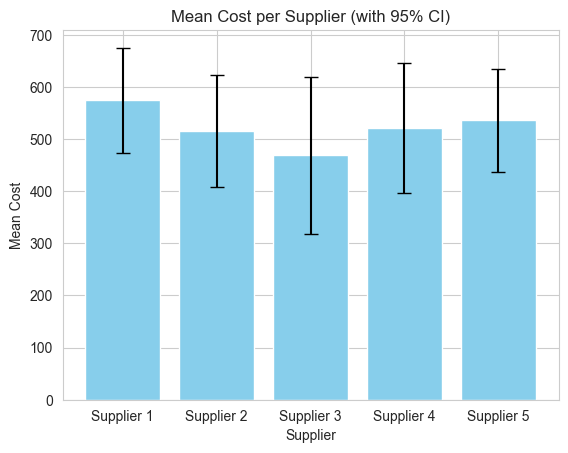

In [23]:
plt.bar(
    costs_compare['supplier_name'],
    costs_compare['Mean Cost'],
    yerr=costs_compare['Mean Cost'] - costs_compare['CI Lower'],
    capsize=5,
    color='skyblue',
)
plt.title('Mean Cost per Supplier (with 95% CI)')
plt.ylabel('Mean Cost')
plt.xlabel('Supplier')
plt.show()

Conclusion:

| Nhà Cung Cấp | Mô Tả |
|---|---|
| **Supplier 1** | **Nhà cung cấp cao cấp - Chi phí cao nhất:** Chi phí trung bình cao nhất ở mức **574.85** (cao hơn 12-23% so với đối thủ cạnh tranh). Có kích thước mẫu lớn nhất (**n=27**) nhưng độ biến động cao (**Std=266.73**). Phù hợp cho các đơn hàng yêu cầu **dịch vụ cao cấp** hoặc **chất lượng đặc biệt**, nhưng cần đánh giá thêm để biện minh cho mức giá cao. |
| **Supplier 2** | **Nhà cung cấp cân bằng tối ưu:** Chi phí trung bình **515.03** với độ tin cậy cao (**n=22**, CI: 407.55-622.50). Cân bằng tốt giữa **chi phí và độ ổn định**, phù hợp cho **các đơn hàng thường xuyên và dài hạn** cần dự báo ngân sách chính xác. Đây là **lựa chọn dự phòng chính** trong chiến lược đa dạng hóa nhà cung cấp. |
| **Supplier 3** | **Nhà cung cấp giá rẻ - Rủi ro cao:** Chi phí trung bình thấp nhất ở mức **468.80**, tiết kiệm 8.8-18.5% so với đối thủ. Tuy nhiên, có **độ biến động cao nhất** (**Std=296.83**) và kích thước mẫu nhỏ (**n=15**), dẫn đến khoảng tin cậy rất rộng (318.58-619.02). Phù hợp cho **đơn hàng có ngân sách hạn chế** sẵn sàng chấp nhận **rủi ro về tính nhất quán giá**. |
| **Supplier 4** | **Nhà cung cấp trung bình - Chưa có lợi thế rõ ràng:** Chi phí **521.81** với độ biến động cao (**Std=269.98**) và kích thước mẫu nhỏ (**n=18**). Khoảng tin cậy rộng (397.09-646.53) phản ánh **độ không chắc chắn cao**. Không có lợi thế cạnh tranh rõ ràng về chi phí hoặc độ ổn định so với Supplier 1 và 4. **Cần thu thập thêm dữ liệu** để đánh giá chính xác hơn. |
| **Supplier 5** | **Nhà cung cấp ổn định nhất - Khuyến nghị chính:** Chi phí **536.02** với **độ lệch chuẩn thấp nhất** (**Std=213.73**), tạo ra khoảng tin cậy hẹp (437.29-634.76). Đây là **nhà cung cấp dự đoán được nhất** và phù hợp cho **các dự án dài hạn** yêu cầu kiểm soát ngân sách chặt chẽ. Mặc dù chi phí cao hơn 4-14%, nhưng **tính nhất quán cao** giúp giảm thiểu rủi ro trong quản lý chuỗi cung ứng. **Nên sử dụng cho 70% nhu cầu**. |

**Khuyến nghị chiến lược:** Áp dụng chiến lược đa dạng hóa với Supplier 4 làm trụ cột chính (70%), Supplier 1 làm dự phòng (20%), và Supplier 2 cho các cơ hội tối ưu chi phí (10%).

### Kiểm tra phân phối

In [24]:
for s in df['supplier_name'].unique():
    data = df[df['supplier_name']==s]['costs']
    stat, p = shapiro(data)
    print(f'Supplier: {s} | p-value={p:.3f}')

Supplier: Supplier 3 | p-value=0.149
Supplier: Supplier 1 | p-value=0.020
Supplier: Supplier 5 | p-value=0.442
Supplier: Supplier 4 | p-value=0.106
Supplier: Supplier 2 | p-value=0.654


Supplier    |  p-value  |  Conclusion                                                                                                            
---|---|---|
Supplier 1  |  0.020    |  Không tuân theo phân phối chuẩn (p < 0.05).
Supplier 2  |  0.654    |  Tuân theo phân phối chuẩn (p > 0.05).    
Supplier 3  |  0.149    |  Tuân theo phân phối chuẩn (p > 0.05).
Supplier 4  |  0.106    |  Tuân theo phân phối chuẩn (p > 0.05).              
Supplier 5  |  0.442    |  Tuân theo phân phối chuẩn (p > 0.05).              

### Kruskal Test

In [25]:
groups = [df[df['supplier_name'] == s]['costs'] for s in df['supplier_name'].unique()]
stat, p = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic = {stat:.3f}, p-value = {p:.4f}")

if p < 0.05:
    print("=> Có sự khác biệt có ý nghĩa thống kê giữa các supplier.")
else:
    print("=> Không có sự khác biệt có ý nghĩa thống kê giữa các supplier.")

Kruskal-Wallis H-statistic = 1.848, p-value = 0.7637
=> Không có sự khác biệt có ý nghĩa thống kê giữa các supplier.


### Anova Test

In [26]:
groups = [df[df['supplier_name'] == s]['costs'] for s in df['supplier_name'].unique()]

stat_anova, p_anova = f_oneway(*groups)
print(f"One-way Anova TEST F-statistic = {stat_anova:.3f}, p-value = {p_anova:.4f}")

if p_anova < 0.05:
    print("=> Có sự khác biệt có ý nghĩa thống kê giữa các supplier.")
else:
    print("=> Không có sự khác biệt có ý nghĩa thống kê giữa các supplier.")

One-way Anova TEST F-statistic = 0.429, p-value = 0.7873
=> Không có sự khác biệt có ý nghĩa thống kê giữa các supplier.


### Kết luận
=> Không có khác biệt lớn về chi phí giữa các supplier → Chi phí không phải tiêu chí phân biệt rõ ràng.


## Supplier nào có doanh thu cao nhất ?

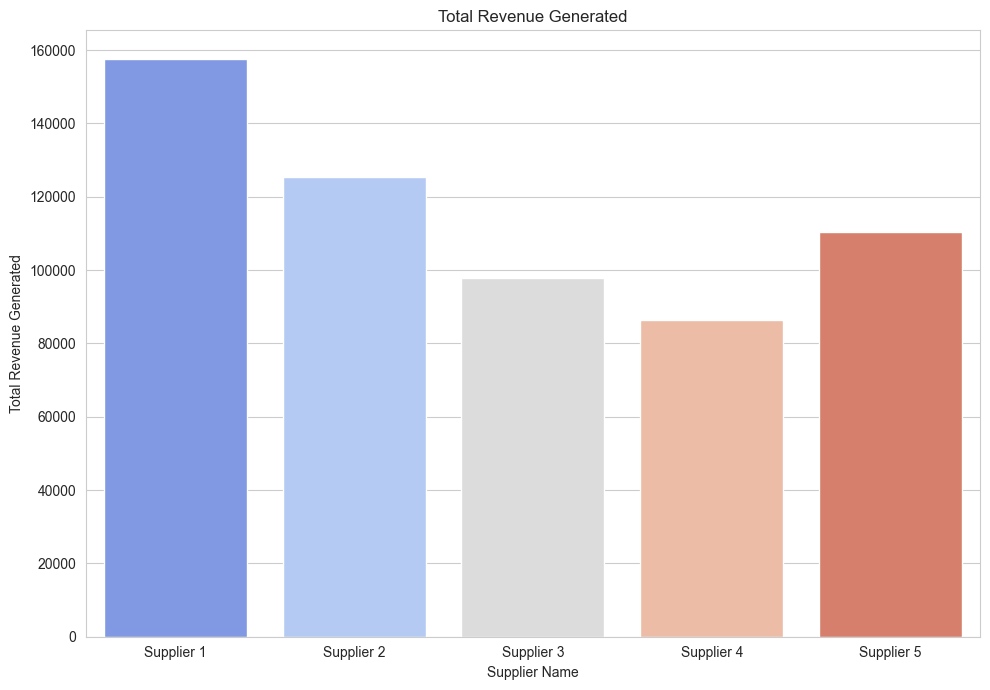

In [27]:
total_revenue_by_supplier = df.groupby('supplier_name')['revenue_generated'].sum().reset_index()

plt.figure(figsize=(10, 7))
sns.barplot(x='supplier_name', y='revenue_generated', data=total_revenue_by_supplier, palette='coolwarm')
plt.title('Total Revenue Generated')
plt.xlabel('Supplier Name')
plt.ylabel('Total Revenue Generated')
plt.tight_layout()
plt.show()

supplier 1 mang lại doanh thu lớn nhất

## Ai có năng lực sản xuất cao nhất ?

In [28]:
prod_compare = (
    df.groupby('supplier_name')['production_volumes']
      .agg(['mean', 'std', 'count'])
      .reset_index()
      .rename(columns={'mean': 'Mean', 'std': 'Std', 'count': 'n'})
)

prod_compare['CI Lower'] = prod_compare['Mean'] - z * (prod_compare['Std'] / np.sqrt(prod_compare['n']))
prod_compare['CI Upper'] = prod_compare['Mean'] + z * (prod_compare['Std'] / np.sqrt(prod_compare['n']))

prod_compare

,supplier_name,Mean,Std,n,CI Lower,CI Upper
0,Supplier 1,501.666667,237.248004,27,412.176203,591.157130
1,Supplier 2,641.136364,289.877198,22,520.004392,762.268335
2,Supplier 3,533.133333,227.891536,15,417.804304,648.462363
3,Supplier 4,653.111111,249.197745,18,537.987626,768.234596
4,Supplier 5,521.166667,288.480451,18,387.895498,654.437836


### Kiểm tra phân phối

In [29]:
for s in df['supplier_name'].unique():
    data = df[df['supplier_name']==s]['production_volumes']
    stat, p = shapiro(data)
    print(f"{s}: p = {p:.3f}")

Supplier 3: p = 0.366
Supplier 1: p = 0.193
Supplier 5: p = 0.015
Supplier 4: p = 0.078
Supplier 2: p = 0.027


Supplier    |  p-value  |  Conclusion                                                                                                            
---|---|---|
Supplier 1  |  0.193    |  Tuân theo phân phối chuẩn (p > 0.05).
Supplier 2  |  0.027    |  Không tuân theo phân phối chuẩn (p < 0.05).   
Supplier 3  |  0.366    |  Tuân theo phân phối chuẩn (p > 0.05).
Supplier 4  |  0.078    |  Tuân theo phân phối chuẩn (p > 0.05).              
Supplier 5  |  0.015    |  Không tuân theo phân phối chuẩn (p < 0.05).              

### Kết luận
=> Không có bằng chứng thống kê để nói rằng năng lực sản xuất của các supplier khác nhau. Trung bình (Mean) có thể khác nhau, ví dụ Supplier 4 cao nhất, nhưng sự khác biệt này có thể do ngẫu nhiên. Vì vậy, không thể khẳng định chắc chắn ai có năng lực sản xuất cao nhất dựa vào dữ liệu hiện tại.

## Supplier nào vừa rẻ vừa ít lỗi? (Trade-off)

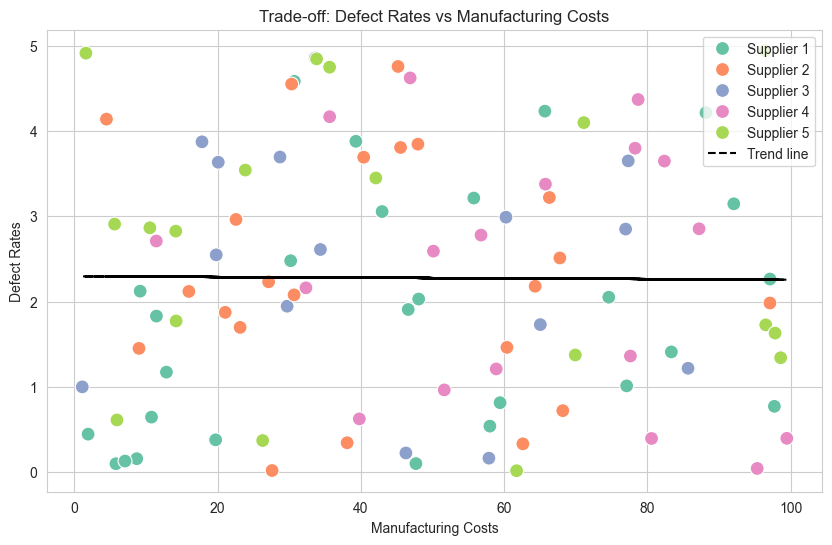

In [30]:
plt.figure(figsize=(10,6))

sns.scatterplot(
    data=df,
    x='manufacturing_costs',
    y='defect_rates',
    hue='supplier_name',
    s=100,
    palette='Set2'
)

# Trend line tổng thể
X = df['manufacturing_costs'].values.reshape(-1,1)
y = df['defect_rates'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
plt.plot(df['manufacturing_costs'], y_pred, color='black', linestyle='--', label='Trend line')

plt.xlabel('Manufacturing Costs')
plt.ylabel('Defect Rates')
plt.title('Trade-off: Defect Rates vs Manufacturing Costs')
plt.legend()
plt.grid(True)
plt.show()

**Kết luận:** Không có Trade-off Defect Rates với Manufacturing Costs

## Có mối quan hệ đánh đổi giữa chi phí và thời gian giao hàng không ? (Trade-off)

In [31]:
# Hệ số tương quan Pearson và Spearman
pearson_corr, pearson_p = pearsonr(df['shipping_costs'], df['shipping_times'])
spearman_corr, spearman_p = spearmanr(df['shipping_costs'], df['shipping_times'])

print(f"Pearson correlation: {pearson_corr:.3f} (p={pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p={spearman_p:.3f})")

Pearson correlation: 0.045 (p=0.656)
Spearman correlation: 0.062 (p=0.540)


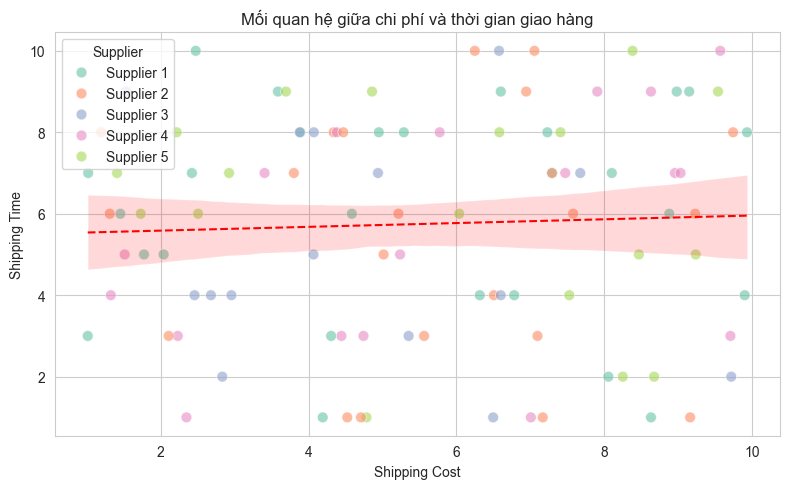

In [56]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    data=df,
    x="shipping_costs",
    y="shipping_times",
    hue="supplier_name",
    palette="Set2",
    alpha=0.6,
    s=60,
)
sns.regplot(
    data=df,
    x="shipping_costs",
    y="shipping_times",
    scatter=False,
    ax=ax,
    color="red",
    line_kws={"linestyle": "--", "linewidth": 1.5},
)
plt.title("Mối quan hệ giữa chi phí và thời gian giao hàng")
plt.xlabel("Shipping Cost")
plt.ylabel("Shipping Time")
plt.legend(title="Supplier")
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

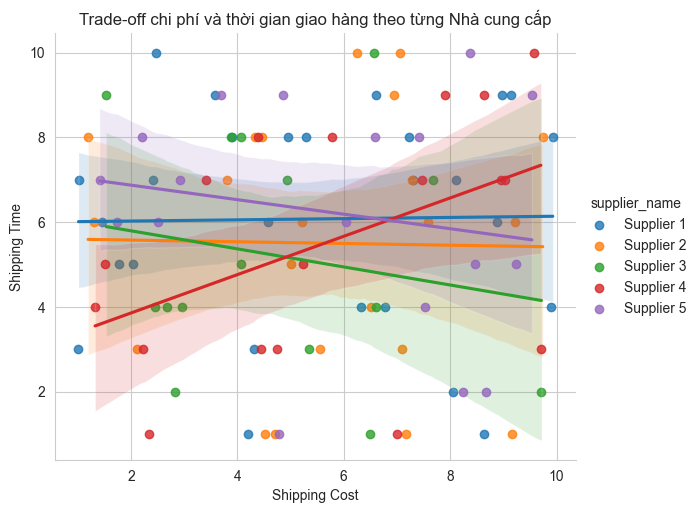

In [57]:
plt.figure(figsize=(8,6))
sns.lmplot(data=df, x='shipping_costs', y='shipping_times', hue='supplier_name', aspect=1.2, height=5)
plt.title("Trade-off chi phí và thời gian giao hàng theo từng Nhà cung cấp")
plt.xlabel("Shipping Cost")
plt.ylabel("Shipping Time")
plt.show()

In [58]:
corr_table = (
    df.groupby('supplier_name')
      .apply(lambda x: pd.Series({
          'Pearson_r': pearsonr(x['shipping_costs'], x['shipping_times'])[0],
          'Spearman_r': spearmanr(x['shipping_costs'], x['shipping_times'])[0],
          'n': len(x)
      }))
      .reset_index()
)

corr_table.sort_values(by='Pearson_r', ascending=True)

,supplier_name,Pearson_r,Spearman_r,n
4,Supplier 5,-0.181786,-0.128969,18.0
2,Supplier 3,-0.173455,-0.139124,15.0
1,Supplier 2,-0.016064,-0.047920,22.0
0,Supplier 1,0.015989,0.097834,27.0
3,Supplier 4,0.462481,0.409646,18.0


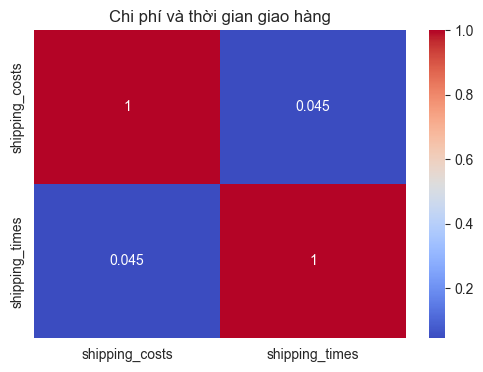

In [61]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['shipping_costs','shipping_times']].corr(method='pearson'), annot=True, cmap='coolwarm')
plt.title("Chi phí và thời gian giao hàng")
plt.show()

# Kiểm tra khả năng đáp ứng đơn hàng của mỗi supplier

In [33]:
summary = df.groupby('supplier_name')['lead_time'].agg(['mean','std','count']).reset_index()
summary['lower'] = summary['mean'] - summary['std']
summary['upper'] = summary['mean'] + summary['std']

summary

,supplier_name,mean,std,count,lower,upper
0,Supplier 1,14.777778,8.550004,27,6.227774,23.327782
1,Supplier 2,18.545455,9.816057,22,8.729397,28.361512
2,Supplier 3,20.133333,8.279637,15,11.853697,28.412970
3,Supplier 4,15.222222,7.922830,18,7.299392,23.145053
4,Supplier 5,18.055556,9.032440,18,9.023116,27.087995


In [34]:
summary = df.groupby('supplier_name').agg(
    avg_stock=('stock_levels', 'mean'),
    avg_order=('order_quantities', 'mean'),
    std_stock=('stock_levels', 'std'),
    std_order=('order_quantities', 'std'),
    n=('stock_levels', 'count')
).reset_index()

summary

,supplier_name,avg_stock,avg_order,std_stock,std_order,n
0,Supplier 1,42.296296,54.000000,33.025415,25.440731,27
1,Supplier 2,46.454545,46.454545,32.357714,25.902247,22
2,Supplier 3,43.600000,42.133333,28.657584,28.379738,15
3,Supplier 4,58.944444,46.777778,30.305255,29.262615,18
4,Supplier 5,49.888889,53.777778,31.180478,26.847183,18


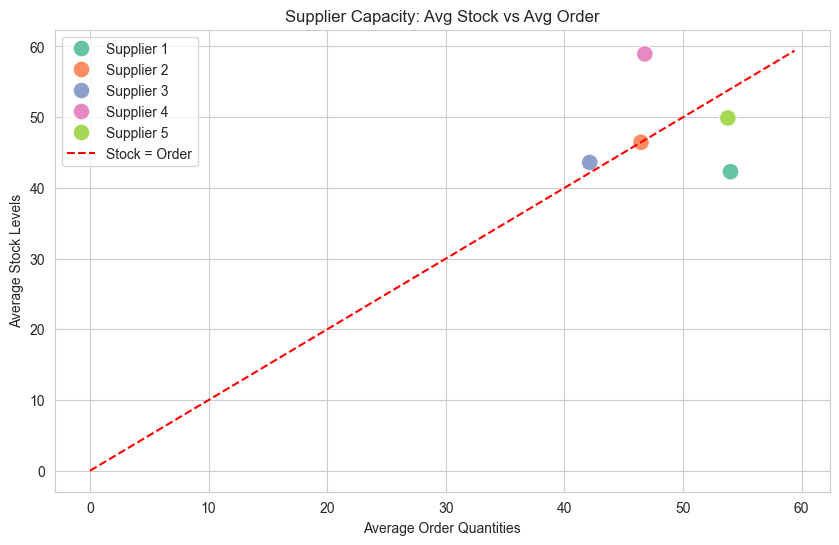

In [35]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=summary,
    x='avg_order',
    y='avg_stock',
    hue='supplier_name',
    s=150,
    palette='Set2'
)

# Thêm line y=x để trực quan "đủ stock vs thiếu stock"
plt.plot([0, summary['avg_order'].max()*1.1], [0, summary['avg_order'].max()*1.1],
         color='red', linestyle='--', label='Stock = Order')

plt.xlabel('Average Order Quantities')
plt.ylabel('Average Stock Levels')
plt.title('Supplier Capacity: Avg Stock vs Avg Order')
plt.grid(True)
plt.legend()
plt.show()

### **Kết luận** 

- Supplier 4 là lựa chọn tổng thể tốt nhất. 
- Họ kết hợp được cả hai yếu tố: giao hàng nhanh (thứ 2) và ổn định nhất (std thấp nhất).

Biểu đồ tán xạ so sánh năng lực cung ứng của các supplier:

| Supplier       | Nhận xét                                           |
| -------------- | -------------------------------------------------- |
| Supplier 4     | Năng lực đáp ứng **tốt nhất**, dư stock và ổn định |
| Supplier 3     | Đáp ứng vừa đủ, khá ổn định                        |
| Supplier 2     | Đáp ứng vừa đủ, trung bình ổn định                 |
| Supplier 1 & 5 | Có nguy cơ **thiếu stock**, cần theo dõi kỹ        |


# Save

## Metadata `.json`

In [36]:
save_metadata(
    df,
    r"../../data/metadata/metadata3.json",
)

## To `.csv`

In [37]:
df.to_csv(
    r"../../data/cleaned/clean3.csv",
    index=False,
    encoding="utf-8",
)